In [ ]:
!pip install statsbombpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 2.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: 

0    Starting XI
1    Starting XI
2     Half Start
3     Half Start
4     Half Start
Name: type, dtype: object


<ipython-input-9-f7ef7c85495a>:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  shots['goal'] = shots['shot_outcome'].apply(lambda x: 1 if x == 'Goal' else 0)
<ipython-input-9-f7ef7c85495a>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots['goal'] = shots['shot_outcome'].apply(lambda x: 1 if x == 'Goal' else 0)
<ipython-input-9-f7ef7c85495a>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all 

Mean Squared Error: 0.1350148714574469
R-squared: -0.157416446768871


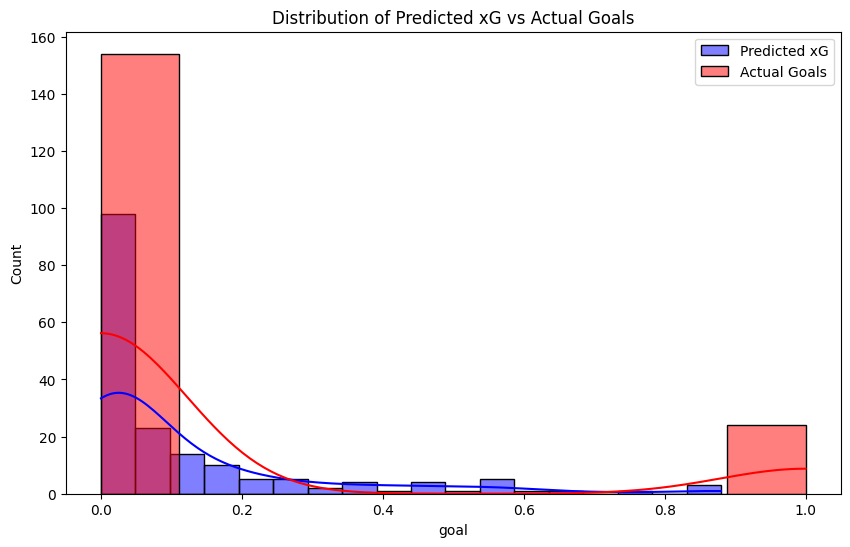

In [ ]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
from statsbombpy import sb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Load the StatsBomb data

# Fetch a list of competitions
competitions = sb.competitions()

# Filter for the competition and season of interest (e.g., La Liga 2017/2018)
competition_id = 11  # La Liga
season_id = 4  # 2017/2018

# Get the match IDs for the selected competition and season
matches = sb.matches(competition_id=competition_id, season_id=season_id)

# Fetch events for each match and concatenate them into a single DataFrame
event_data = pd.concat([sb.events(match_id) for match_id in matches['match_id']])

# Step 3: Prepare the data
# Check the data type of the 'type' column
print(event_data['type'].head())

# If 'type' is a dictionary, the original code will work; otherwise, you may need to parse it or adjust the logic.
if isinstance(event_data['type'].iloc[0], dict):
    # Filter out only shots
    shots = event_data[event_data['type'].apply(lambda x: x['name']) == 'Shot']
else:
    # If 'type' is a string, filter directly using the string value
    shots = event_data[event_data['type'] == 'Shot']

# Feature engineering
shots['goal'] = shots['shot_outcome'].apply(lambda x: 1 if x == 'Goal' else 0)
shots['x'], shots['y'] = zip(*shots['location'])
shots['distance_to_goal'] = np.sqrt((120 - shots['x']) ** 2 + (40 - shots['y']) ** 2)
shots['angle_to_goal'] = np.arctan2(7.32, shots['distance_to_goal'])

# Prepare the features and labels
X = shots[['x', 'y', 'distance_to_goal', 'angle_to_goal']]
y = shots['goal']

# Step 4: Train the xG model

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 5: Evaluate the model

# Predict xG on the test set
y_pred = model.predict(X_test)

# Calculate and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Step 6: Visualize the results

# Plot the distribution of predicted xG vs actual goals
plt.figure(figsize=(10, 6))
sns.histplot(y_pred, kde=True, label='Predicted xG', color='blue')
sns.histplot(y_test, kde=True, label='Actual Goals', color='red')
plt.legend()
plt.title('Distribution of Predicted xG vs Actual Goals')
plt.show()